In [114]:
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [115]:
from pykalman import KalmanFilter

In [116]:
def adf_test_spread(x, y): ## a stationarity test, of the residual of stock prices x and y
    df = pd.DataFrame({'x': x, 'y' : y})
    est = sm.OLS(df.y, df.x) ## OLS = Ordinary Least Squares, for linear regression
    est.fit()
    df['hedge_ratio'] = est.params[0]
    df['intercept'] = est.params[1]
    df['spread'] = df.y - df.x * df.hedge_ratio - df.intercept
    res = ts.adfuller(df['spread'])
    return res[1]

In [117]:
from numpy import log, polyfit, sqrt, std, subtract

In [118]:
def hurst_test(time_ser):
    lags = [i for i in range(2, 200)]
    tau = [(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags] ## Root(Variance) = std_dev
    poly = polyfit(log(lags), log(tau), 1) ## np.polyfit(x, y, deg), linear regression to find slope
    return poly[0] ## Return value is an array of coeffecients in descending order of powers, poly[0] is the slope

In [119]:
def half_life_spread(x):
    
    x_lag = x.shift(1)
    x_lag.iloc[0] = x_lag.iloc[1]
    diff = x - x_lag
    diff.iloc[0] = diff.iloc[1]
    
    x_lag_2 = sm.add_constant(x_lag)
    est = sm.OLS(diff, x_lag_2)
    res = est.fit()

    half_life = int(round(-np.log(2) / res.params[1],0))
    if half_life <= 0:
        half_life = 1
    return half_life

In [120]:
def KF_Avg(x):
    """Smoothens a stock price series, removing all possible noise"""
    kf = KalmanFilter(transition_matrices = [1], ## System Model: priori_price_on_next_day = price_on_last_day
                      observation_matrices = [1], ## Measuring stock price on the next day
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, state_covs = kf.filter(x.values) ## x is assumed to be sequential measurements of the stock price
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

In [121]:
def KF_linear_regression(x, y):
    """Uses a Kalman Filter to determine the linear regression parameters for stocks x and y"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    ## alpha is intercept, beta is the slope

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance = np.ones((2, 2)),
                      transition_matrices = np.eye(2), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)
    
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [122]:
def backtest(x, y, allowed_drawdown = 0.05, stop_loss = 0.05):
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KF_linear_regression(KF_Avg(x), KF_Avg(y))

    df1['hr'] = state_means[:,0] ## The hedge ratio
    df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept

    halflife = half_life_spread(df1['spread'])

    meanSpread = df1.spread.rolling(window= 1 * halflife).mean()
    stdSpread = df1.spread.rolling(window= 1 * halflife).std()

    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    entryZscore = 2
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & ( df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1 ## num units long updated for the indices where df1['long entry'] is true
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad') ## each NaN filled with the prev non-NaN value


    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) <  entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & ( df1.zScore.shift(1) >  exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'],'num units short'] = -1 ## num units short updated for the indices where df1['short entry'] is true
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad') ## each NaN filled with the prev non-NaN value

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread_pct_chg'] = df1.spread.diff()/df1.spread
    df1['port rets'] = df1['spread_pct_chg'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    

    df1['drawdown'] = ffn.to_drawdown_series(df1['cum rets'])
    idx = (df1['drawdown'] < - allowed_drawdown) | (df1['cum rets'] < 1 - stop_loss)
    
    first_idx = idx.idxmax() if idx.any() else None

    if first_idx is not None:
        df1.loc[first_idx:, 'cum rets'] = np.nan
        df1.loc[first_idx:, 'port_rets'] = 0

    df1['cum rets'] = df1['cum rets'].fillna(method='pad')

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe


In [123]:
def find_coint_pairs(df, critical_val = 0.05):
    n = df.shape[1] ## Number of different stocks
    p_value_mat = np.zeros((n, n))

    stocks = df.keys()
    feasible_pairs = []
    for i in range(0, n):
        s1 = df[stocks[i]]
        for j in range(i + 1, n):
            s2 = df[stocks[j]]
            
            p_val = (ts.coint(s1, s2))[1]

            p_value_mat[i, j] = p_val
            if p_val < critical_val: ## The pair is cointegrated
                row = [stocks[i], stocks[j], p_val]
                feasible_pairs.append(row)
    feasible_pairs = pd.DataFrame(feasible_pairs, columns = ['S1', 'S2', 'Pvalue'])
    return p_value_mat, feasible_pairs

In [124]:
df = pd.read_csv('it_train.csv', parse_dates=True, index_col='Date')

In [125]:
df.index

DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14',
               ...
               '2024-12-09', '2024-12-10', '2024-12-11', '2024-12-12',
               '2024-12-13', '2024-12-16', '2024-12-17', '2024-12-18',
               '2024-12-19', '2024-12-20'],
              dtype='datetime64[ns]', name='Date', length=733, freq=None)

In [126]:
from datetime import time, timedelta
from dateutil.relativedelta import relativedelta

In [136]:
start_check = datetime(2022, 1, 1)
end_check = start_check + relativedelta(months=6)

results_dict_list = []

while end_check <= datetime(2025,1, 1):
    print(start_check)
    _, poss_pairs = find_coint_pairs(df.loc[start_check: end_check])
    for pair in poss_pairs.values:
        # print(pair)
        res = backtest(df.loc[end_check - relativedelta(months = 1) : end_check + relativedelta(months = 1)][pair[0]]
                       , df.loc[end_check - relativedelta(months = 1) : end_check + relativedelta(months = 1)][pair[1]],
                       allowed_drawdown=0.2, stop_loss=0.10)
        res_dict = {'pair' : pair[0:2], 'sharpe' : res[1], 'returns' : res[0], 'p_val' : pair[2]}
        results_dict_list.append(res_dict)
    start_check += relativedelta(months = 1)
    end_check = start_check + relativedelta(months=6)


2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00


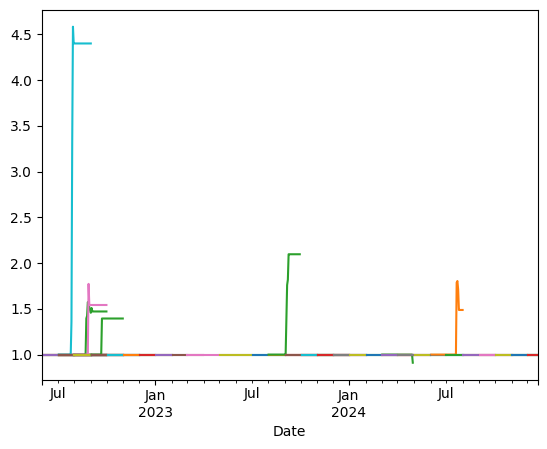

In [128]:
for r in results_dict_list:
    r['returns'].plot()

In [138]:
for r in results_dict_list:
    print(f'{r['returns'][-1]}, {r['p_val']}')


1.0, 0.001084368260320736
1.0, 0.04914671991574173
1.0, 0.004172792199254238
1.0, 0.005477078583642123
1.0, 0.037733990666677174
1.311180229291263, 0.046140901095431286
1.0, 0.036317528059050086
1.0, 0.006139651432674467
1.0, 0.03381642186169774
1.0, 0.00969476236619963
1.0, 0.012573377270312061
1.0, 0.04977271596460818
1.0, 0.0012771557473159245
1.0, 0.01623590088070966
1.0, 0.004295722194363454
1.0, 0.0027924984967308037
1.0, 0.0158754476482912
1.0, 0.04107483643206186
1.0, 0.002978277661606787
1.0, 0.03057278870139921
1.0, 0.036949216105368374
1.0, 0.009306514282359048
1.0, 0.0455883495449549
1.0, 0.008097057147234951
1.1813018255911591, 0.041252134044576214
1.43400237823082, 0.030312743238439018
1.1254397843554373, 0.0028559141523455296
1.0, 0.010419678395638622
1.0, 0.015139131282062413
1.0, 0.012317172508408919
1.193100041092943, 0.020603911924869853
1.0, 0.0007624527110544316
1.0, 0.023259692660614496
1.0, 0.001871801896849473
1.0, 0.02517871270050543
1.0, 0.0036143392178871114


In [129]:
prof_count = 0
prof = 0
loss_count = 0
loss = 0
for t in results_dict_list:
    
    x = t['returns'][-1] - 1
    if x > 0:
        prof_count += 1
        prof += x
    elif x < 0:
        loss_count += 1
        loss += x
print(f'No. of profitable positions: {prof_count}, avg_profit = {prof/prof_count}')
print(f'No. of loss-making positions: {loss_count}, avg_loss = {loss/loss_count if loss_count else 0}')
print(f'No. of positions with no-change/no trading opportunities: {len(results_dict_list) - prof_count - loss_count}')

No. of profitable positions: 6, avg_profit = 1.0652041437547006
No. of loss-making positions: 1, avg_loss = -0.08860793062346417
No. of positions with no-change/no trading opportunities: 87


In [130]:
df = pd.read_csv('bank_test_5yr.csv', index_col='Date', parse_dates=True)

In [131]:
start_check = datetime(2022, 3, 1)
end_check = start_check + relativedelta(months=6)

results_dict_list = []

while end_check <= datetime(2025,1, 1):
    print(start_check)
    _, poss_pairs = find_coint_pairs(df.loc[start_check: end_check])
    for pair in poss_pairs.values:
        # print(pair)
        res = backtest(df.loc[end_check - relativedelta(months = 1) : end_check + relativedelta(months = 2)][pair[0]]
                       , df.loc[end_check - relativedelta(months = 1) : end_check + relativedelta(months = 2)][pair[1]],
                       allowed_drawdown= 0.20, stop_loss=0.1)
        res_dict = {'pair' : pair[0:2], 'sharpe' : res[1], 'returns' : res[0]}
        results_dict_list.append(res_dict)
    start_check += relativedelta(months = 2)
    end_check = start_check + relativedelta(months=6)


2022-03-01 00:00:00
2022-05-01 00:00:00
2022-07-01 00:00:00
2022-09-01 00:00:00
2022-11-01 00:00:00
2023-01-01 00:00:00
2023-03-01 00:00:00
2023-05-01 00:00:00
2023-07-01 00:00:00
2023-09-01 00:00:00
2023-11-01 00:00:00
2024-01-01 00:00:00
2024-03-01 00:00:00
2024-05-01 00:00:00
2024-07-01 00:00:00


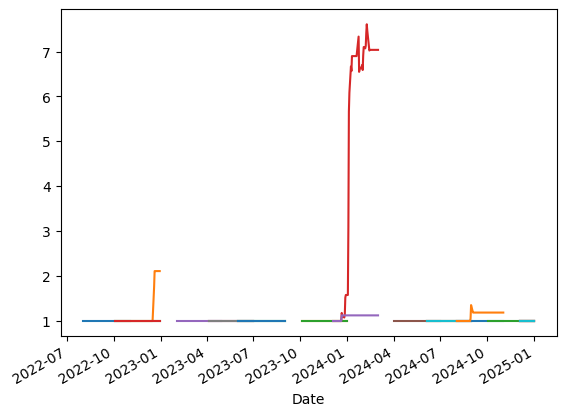

In [132]:
for r in results_dict_list:
    r['returns'].plot()

In [133]:
prof_count = 0
prof = 0
loss_count = 0
loss = 0
for t in results_dict_list:
    
    x = t['returns'][-1] - 1
    if x > 0:
        prof_count += 1
        prof += x
    elif x < 0:
        loss_count += 1
        loss += x
print(f'No. of profitable positions: {prof_count}, avg_profit = {prof/prof_count}')
print(f'No. of loss-making positions: {loss_count}, avg_loss = {loss/loss_count if loss_count else 0}')
print(f'No. of positions with no-change/no trading opportunities: {len(results_dict_list) - prof_count - loss_count}')

No. of profitable positions: 4, avg_profit = 1.8656130942828661
No. of loss-making positions: 0, avg_loss = 0
No. of positions with no-change/no trading opportunities: 26


In [135]:
(prof + loss)/len(results_dict_list)

0.24874841257104882